---
layout: post
title: Blog Post 5
---

In this blog post, we will be using several new skills, methods, and concepts related to image classification in TensorFlow, an open-source library for machine learning and artificial intelligence.

Our task is to distinguish between cats and dogs by training a machine learning model.

Major parts of this Blog Post, including several code chunks, are based on the [TensorFlow Transfer Learning Tutorial](https://www.tensorflow.org/tutorials/images/transfer_learning).

## §1. Load Packages and Obtain Data

We will start be creating a block of code that will hold our import statements.

In [82]:
#importing packages 
import os
import tensorflow as tf
from tensorflow.keras import utils, layers, models 
import matplotlib.pyplot as plt
import numpy as np

Now, let’s access the data. We’ll use a sample data set provided by the TensorFlow team that contains labeled images of cats and dogs.

In [2]:
# location of data
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

# download the data and extract it
path_to_zip = utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

# construct paths
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

# parameters for datasets
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

# construct train and validation datasets 
train_dataset = utils.image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = utils.image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

# construct the test dataset by taking every 5th observation out of the validation dataset
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

68616192/68606236 [==============================] - 1s 0us/step
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


By running this code, we have created TensorFlow Datasets for training, validation, and testing. Notice that we have used a special-purpose `keras` utility called `image_dataset_from_directory` to construct a Dataset. Let's break the argument into pieces:
- The first argument: where the images are located
- The shuffle argument: when retrieving data from this directory, the order should be randomized.
- The batch_size argument: determines how many data points are gathered from the directory at once. 

Paste the following code into the next block. This is technical code related to rapidly reading data. 

In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Working with Datasets

Let’s briefly explore our data set.  
We are going to write a function to create a two-row visualization. This function gets images from one batch of our training data (32 images) and examines the label. If it is labeled as a cat we put it in a list of `cat_images` and if it is a dog we put it in a list of `dog_images`. We then plot the images in a 2 row x 3 column grid. In the first row, we have three random pictures of cats. In the second row, we have three random pictures of dogs. 

In [4]:
def two_row_visualization():
    plt.figure(figsize=(10, 10))
    # set labels
    class_names = ['cats', 'dogs']
      #organize images into two different lists
    for images, labels in train_dataset.take(1):
        cat_images = []
        dog_images = []
    while len(cat_images) <= 3 & len(dog_images) <=3:
        for i in range(32): #go through batch of 32 images
            if class_names[labels[i]] == 'dogs': #if label == dog, put in dog list
                  dog_images.append(images[i]) #if label == cat, put in cat list 
            else:
                  cat_images.append(images[i])
    fig,ax = plt.subplots(2, 3)
    for i in range(3):#plot the images in two seperate rows
      # print cat row 
      ax[0,i].imshow(cat_images[i].numpy().astype("uint8"))
      ax[0,i].axis('off')
      ax[0,i].set_title('Cat')
      # print dog row
      ax[1,i].set_title('Dog')
      ax[1,i].imshow(dog_images[i].numpy().astype("uint8"))
      ax[1,i].axis('off')

Let's test if our code works:

In [ ]:
two_row_visualization()

![Blog-Post-5-Plot1.png](https://raw.githubusercontent.com/JadenWSR/JadenWSR.github.io/master/images/Blog-Post-5-Plot1.png)

Great! Our function works successfully!

### Check Label Frequencies

First, we will create an iterator called `labels`.

In [7]:
labels_iterator= train_dataset.unbatch().map(lambda image, label: label).as_numpy_iterator()

We would like to compute the number of images in our training data with label 0 (cats) and label 1 (dogs). Why do we care about this? We need to know the most frequent label since our baseline machine learning model is likely to guess that label!

To find the number of labels corresponding to 1, we simple take the sum of the iterator.

In [8]:
sum(labels_iterator)

1000

Thus, we have 1000 dog images out of 2000 images. The rest 1000 images will be labeled 0, which are cat images.

As we can see, the ratio is split 50-50 between cat images and dog images. If we were to implement a benchmark model that predicts based on which animal is more frequent in the dataset, it would predict either cats or dogs 100% of the time with 50% accuracy. We’ll treat this as the benchmark for improvement. Our models should do much better than baseline in order to be considered good data science achievements!

## §2. First Model

Convolution is a mathematical operation commonly used to extract features (meaningful properties) from images. The idea of image convolution is pretty simple. We define a kernel matrix containing some numbers, and we "slide it over" the input data. At each location, we multiply the data values by the kernel matrix values, and add them together.

There are lots of convolutional kernels we could potentially use. How do we know which ones are meaningful? In practice, we don't. So, we treat them as parameters, and learn them from data as part of the model fitting process. This is exactly what the `Conv2d` layer allows us to do.

The most common approach is to alternate `Conv2D` layers with `MaxPooling2D` layers. Pooling layers act as "summaries" that reduce the size of the data at each step. After we're done doing "2D stuff" to the data, we then need to Flatten the data from 2d to 1d in order to pass it through the final Dense layers, which form the prediction.

In [9]:
# Create our sequntial model similarly to in lecture 
model1 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(160, 160, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1)
])


Let's take a look at our model:

In [10]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 158, 158, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 79, 79, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 77, 77, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 38, 38, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 36, 36, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 18, 18, 32)      

We will need to compile the model before training it. Since there are two classes, use the `tf.keras.losses.BinaryCrossentropy` loss with `from_logits=True` since the model provides a linear output.

In [11]:
model1.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
history = model1.fit(train_dataset, 
                     epochs=20, 
                     validation_data=validation_dataset)

Epoch 1/20
63/63 [==============================] - 5s 63ms/step - loss: 5.7995 - accuracy: 0.5310 - val_loss: 0.6777 - val_accuracy: 0.5755
Epoch 2/20
63/63 [==============================] - 4s 61ms/step - loss: 0.6054 - accuracy: 0.6280 - val_loss: 0.6584 - val_accuracy: 0.6126
Epoch 3/20
63/63 [==============================] - 4s 63ms/step - loss: 0.4850 - accuracy: 0.7340 - val_loss: 0.6851 - val_accuracy: 0.6287
Epoch 4/20
63/63 [==============================] - 4s 60ms/step - loss: 0.3535 - accuracy: 0.8360 - val_loss: 0.8535 - val_accuracy: 0.6101
Epoch 5/20
63/63 [==============================] - 4s 59ms/step - loss: 0.2474 - accuracy: 0.8960 - val_loss: 0.9921 - val_accuracy: 0.6089
Epoch 6/20
63/63 [==============================] - 4s 60ms/step - loss: 0.1774 - accuracy: 0.9255 - val_loss: 1.4491 - val_accuracy: 0.6163
Epoch 7/20
63/63 [==============================] - 6s 91ms/step - loss: 0.1527 - accuracy: 0.9385 - val_loss: 1.3678 - val_accuracy: 0.6101
Epoch 8/20
63

Let's create a function to visualize our history:

In [13]:
def visualize_history(history, min_acc):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.axhline(y= min_acc, color='black', label='Minimum accuracy = {m}%'.format(m=round(min_acc*100, 1)))
    plt.axhline(y=0.50, color='green', label='Baseline accuracy = 50%')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

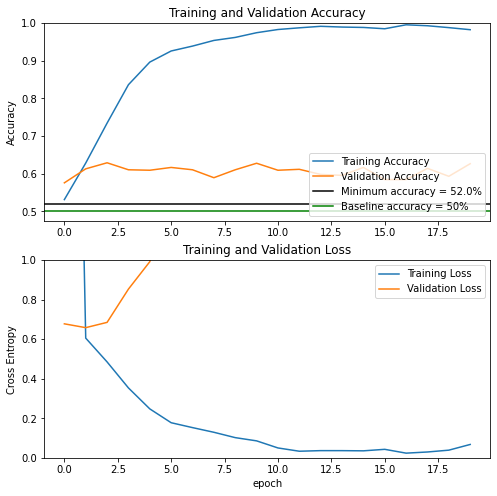

In [14]:
visualize_history(history, 0.52)

![Blog-Post-5-Plot2.png](https://raw.githubusercontent.com/JadenWSR/JadenWSR.github.io/master/images/Blog-Post-5-Plot2.png)

The accuracy of my model stabilized between **57% and 63%** during training. Compared with the baseline, it has about 7-13% better accuracy. We have reached our goal and consistently achieved at least a 52% validation accuracy. However, since the training accuracy is much higher than the validation accuracy we observe overfitting in model1. We could improve this in future models.

## §3. Model with Data Augmentation

Since we don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce overfitting.

Data augmentation refers to the practice of including modified copies of the same image in the training set. For example, a picture of a cat is still a picture of a cat even if we flip it upside down or rotate it 90 degrees. We will include the transformed versions of these images in our training process to expose our model to different aspects of the training set.

After checking the documentations, we will do the following two steps:
- 1. Create a `tf.keras.layers.RandomFlip()` layer. Make a plot of the original image and a few copies to which RandomFlip() has been applied. 
- 2. Create a `tf.keras.layers.RandomRotation()` layer. Then, make a plot of both the original image and a few copies to which RandomRotation() has been applied.

In [128]:
random_flip = tf.keras.Sequential([
    # including the RandomFlip layer
    layers.RandomFlip('horizontal_and_vertical'),
])

In [ ]:
for images, labels in train_dataset.take(1):
    fig,ax = plt.subplots(1,4, figsize = (20,20)) #create plot
    image1 = images[0]
    ax[0].imshow(image1.numpy().astype("uint8")) #plot original image
    ax[0].set_title('Original')
    ax[0].axis('off')
    for i in range(3):
        test = random_flip(tf.expand_dims(image1, 0)) #plot random flipped image
        ax[i+1].imshow(test[0]/225)
        ax[i+1].axis('off')
        ax[i+1].set_title('Random Flip '+str(i+1))

![Blog-Post-5-Plot3.png](https://raw.githubusercontent.com/JadenWSR/JadenWSR.github.io/master/images/Blog-Post-5-Plot3.png)

In [126]:
random_rotation = tf.keras.Sequential([
    layers.RandomRotation(factor=0.2, fill_mode='reflect', interpolation='bilinear',
    seed=None) 
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


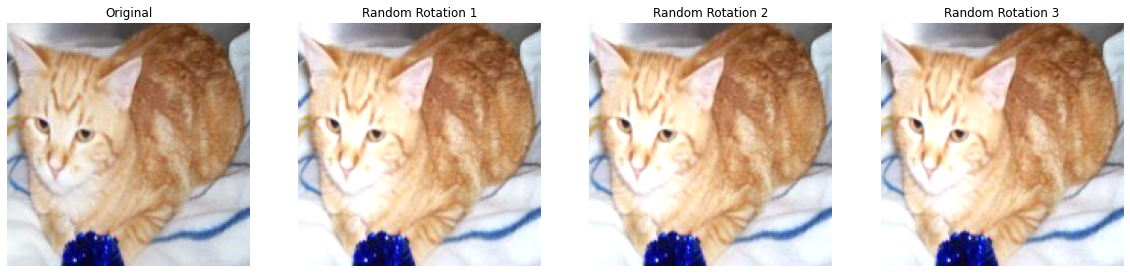

In [127]:
for images, labels in train_dataset.take(1):
    fig,ax = plt.subplots(1,4, figsize = (20,20)) #create plot
    ax[0].imshow(images[0].numpy().astype("uint8")) #plot original image
    ax[0].set_title('Original')
    ax[0].axis('off')
    for i in range(3):
        test = random_rotation(tf.expand_dims(images[0], 0)) #plot random flipped image
        ax[i+1].imshow(test[0]/225)
        ax[i+1].axis('off')
        ax[i+1].set_title('Random Rotation '+str(i+1))

![Blog-Post-5-Plot4.png](https://raw.githubusercontent.com/JadenWSR/JadenWSR.github.io/master/images/Blog-Post-5-Plot4.png)

Great! Above two augmentation layers work! Next, we are going to create a new `tf.keras.models.Sequential` model called `model2` in which the first two layers are augmentation layers. We will use a `RandomFlip()` layer and a `RandomRotation()` layer.

In [365]:
# Create our sequntial model similarly to in lecture 
model2 = models.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.25),
    
    layers.Conv2D(32, (10, 5), activation='relu', input_shape=(160, 160, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
 
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1)
])

In [366]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [367]:
history1 = model2.fit(train_dataset, 
                     epochs=20, 
                      validation_data=validation_dataset)

Epoch 1/20
63/63 [==============================] - 6s 70ms/step - loss: 9.1512 - accuracy: 0.5225 - val_loss: 0.6733 - val_accuracy: 0.5866
Epoch 2/20
63/63 [==============================] - 4s 64ms/step - loss: 0.6780 - accuracy: 0.5530 - val_loss: 0.6685 - val_accuracy: 0.6015
Epoch 3/20
63/63 [==============================] - 4s 65ms/step - loss: 0.6591 - accuracy: 0.5800 - val_loss: 0.6348 - val_accuracy: 0.6139
Epoch 4/20
63/63 [==============================] - 4s 64ms/step - loss: 0.6583 - accuracy: 0.5875 - val_loss: 0.6432 - val_accuracy: 0.5990
Epoch 5/20
63/63 [==============================] - 4s 64ms/step - loss: 0.6456 - accuracy: 0.6050 - val_loss: 0.6214 - val_accuracy: 0.6324
Epoch 6/20
63/63 [==============================] - 4s 65ms/step - loss: 0.6403 - accuracy: 0.6020 - val_loss: 0.6473 - val_accuracy: 0.6324
Epoch 7/20
63/63 [==============================] - 4s 65ms/step - loss: 0.6443 - accuracy: 0.5920 - val_loss: 0.6234 - val_accuracy: 0.6188
Epoch 8/20
63

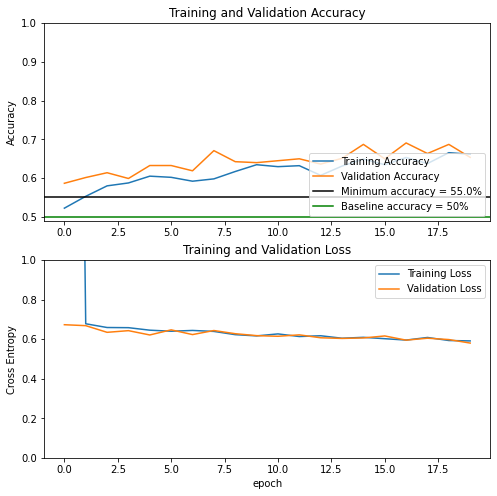

In [368]:
visualize_history(history1, 0.55)

![Blog-Post-5-Plot5.png](https://raw.githubusercontent.com/JadenWSR/JadenWSR.github.io/master/images/Blog-Post-5-Plot5.png)

The accuracy of my model stabilized between **60% and 65%** during training. Compared with the model1, it has about 2% better accuracy in average. This time we consistently achieved at least a 55% validation accuracy. Model2 is doing slightly better than model1, and it is harder for us to train. Since the training accuracy is close to the validation accuracy we did not observe overfitting in model2.

## §4. Data Preprocessing

In this case, the original data has pixels with RGB values between 0 and 255, but many models will train faster with RGB values normalized between 0 and 1, or possibly between -1 and 1. It can be helpful to make simple transformations to the input data. These are mathematically identical situations, since we can always just scale the weights. By normalizing our RGB values in this way, we could minimize training energy need to have the weights adjust to the data scale and maximize training energy needed for handling the actual signal in the data!

This code block creates a model layer which will process our input images.

In [138]:
i = tf.keras.Input(shape=(160, 160, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(i)
preprocessor = tf.keras.Model(inputs = [i], outputs = [x])

Next, we will incorporate the `preprocessor` layer as the very first layer, before the data augmentation layers. We will then fit a model called model3.

In [165]:
# Create our sequntial model similarly to in lecture 
model3 = models.Sequential([
    # Preprocessor
    preprocessor,
    
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
    
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(160, 160, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1)
])

In [166]:
model3.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [223]:
model3.summary()

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 160, 160, 3)       0         
                                                                 
 random_flip_34 (RandomFlip)  (None, 160, 160, 3)      0         
                                                                 
 random_rotation_25 (RandomR  (None, 160, 160, 3)      0         
 otation)                                                        
                                                                 
 conv2d_57 (Conv2D)          (None, 158, 158, 32)      896       
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 79, 79, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_58 (Conv2D)          (None, 77, 77, 32)      

In [167]:
history2 = model3.fit(train_dataset, 
                     epochs=20, 
                     validation_data=validation_dataset)

Epoch 1/20
63/63 [==============================] - 5s 63ms/step - loss: 0.6936 - accuracy: 0.5420 - val_loss: 0.6538 - val_accuracy: 0.6485
Epoch 2/20
63/63 [==============================] - 4s 59ms/step - loss: 0.6415 - accuracy: 0.6130 - val_loss: 0.6201 - val_accuracy: 0.6114
Epoch 3/20
63/63 [==============================] - 4s 60ms/step - loss: 0.6241 - accuracy: 0.6115 - val_loss: 0.6704 - val_accuracy: 0.6485
Epoch 4/20
63/63 [==============================] - 4s 60ms/step - loss: 0.6024 - accuracy: 0.6465 - val_loss: 0.5820 - val_accuracy: 0.6708
Epoch 5/20
63/63 [==============================] - 4s 60ms/step - loss: 0.6200 - accuracy: 0.6325 - val_loss: 0.5890 - val_accuracy: 0.6658
Epoch 6/20
63/63 [==============================] - 4s 61ms/step - loss: 0.5854 - accuracy: 0.6845 - val_loss: 0.5681 - val_accuracy: 0.6856
Epoch 7/20
63/63 [==============================] - 4s 61ms/step - loss: 0.5887 - accuracy: 0.6635 - val_loss: 0.5626 - val_accuracy: 0.6671
Epoch 8/20
63

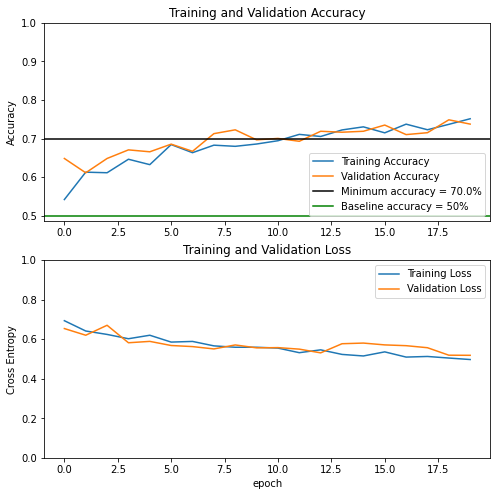

In [168]:
visualize_history(history2, 0.7)

![Blog-Post-5-Plot6.png](https://raw.githubusercontent.com/JadenWSR/JadenWSR.github.io/master/images/Blog-Post-5-Plot6.png)

The accuracy of my model stabilized between **70% and 75%** during training. Compared with model1, it has about 5-15% better accuracy. We consistently achieved at least a 70% validation accuracy. Model3 is doing much better than model1. Since the training accuracy is very close to the validation accuracy we did not observe overfitting in model3.

## §5. Transfer Learning

In the previous steps we’ve been training models for distinguishing between cats and dogs from scratch. In some cases, however, someone might already have trained a model that does a related task, and might have learned some relevant patterns.The next step, we are going to first access a pre-existing “base model”, incorporate it into a full model for our current task, and then train that model.

We will take an exisitng model named `MobileNetV2` and fine tune a layer after it to focus on only cats and dogs.

In [236]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

i = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(i, training = False)
base_model_layer = tf.keras.Model(inputs = [i], outputs = [x])

9420800/9406464 [==============================] - 0s 0us/step


In [263]:
model4 = tf.keras.Sequential([
    # Preprocessor
    preprocessor,
    # Data Augmentation
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.25),

    # Base model 
    base_model_layer,
    layers.GlobalMaxPooling2D(),
    layers.Dropout(0.2),
    layers.Dense(1)
])

In [264]:
model4.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [266]:
model4.summary()

Model: "sequential_76"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 160, 160, 3)       0         
                                                                 
 random_flip_66 (RandomFlip)  (None, 160, 160, 3)      0         
                                                                 
 random_rotation_57 (RandomR  (None, 160, 160, 3)      0         
 otation)                                                        
                                                                 
 model_2 (Functional)        (None, 5, 5, 1280)        2257984   
                                                                 
 global_max_pooling2d_5 (Glo  (None, 1280)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_65 (Dropout)        (None, 1280)            

In [265]:
history3 = model4.fit(train_dataset, 
                     epochs=20, 
                     validation_data=validation_dataset)

Epoch 1/20
63/63 [==============================] - 8s 76ms/step - loss: 0.7379 - accuracy: 0.7595 - val_loss: 0.1736 - val_accuracy: 0.9270
Epoch 2/20
63/63 [==============================] - 4s 66ms/step - loss: 0.4593 - accuracy: 0.8530 - val_loss: 0.1206 - val_accuracy: 0.9468
Epoch 3/20
63/63 [==============================] - 4s 65ms/step - loss: 0.4147 - accuracy: 0.8580 - val_loss: 0.1056 - val_accuracy: 0.9604
Epoch 4/20
63/63 [==============================] - 4s 67ms/step - loss: 0.4294 - accuracy: 0.8590 - val_loss: 0.1097 - val_accuracy: 0.9530
Epoch 5/20
63/63 [==============================] - 4s 66ms/step - loss: 0.3661 - accuracy: 0.8770 - val_loss: 0.0828 - val_accuracy: 0.9691
Epoch 6/20
63/63 [==============================] - 4s 67ms/step - loss: 0.3537 - accuracy: 0.8790 - val_loss: 0.0881 - val_accuracy: 0.9579
Epoch 7/20
63/63 [==============================] - 4s 66ms/step - loss: 0.3471 - accuracy: 0.8790 - val_loss: 0.0892 - val_accuracy: 0.9666
Epoch 8/20
63

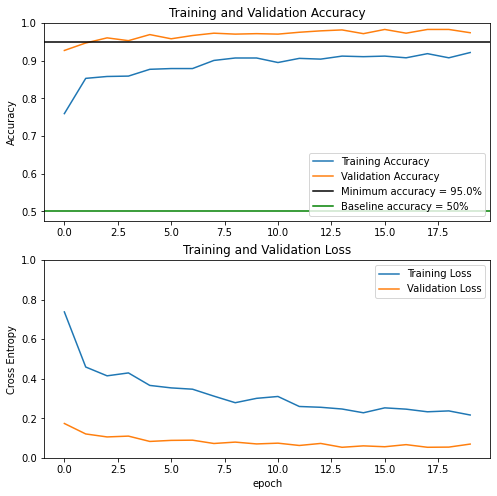

In [267]:
visualize_history(history3, 0.95)

![Blog-Post-5-Plot7.png](https://raw.githubusercontent.com/JadenWSR/JadenWSR.github.io/master/images/Blog-Post-5-Plot7.png)

The accuracy of my model stabilized between **95% and 98%** during training. Compared with model3, it has about 20-25% better accuracy. We have reached our goal and consistently achieved at least a 95% validation accuracy. Model4 is doing much better than model3, and it is our best model so far. Since the training accuracy is close to the validation accuracy we did not observe overfitting in model4.

## §6. Score on Test Data

Finally, let us evaluate the accuracy of our most performant model, i.e., `model4`, on the unseen `test_dataset` and see how we do!

In [269]:
model4.evaluate(test_dataset)

6/6 [==============================] - 1s 83ms/step - loss: 0.0318 - accuracy: 0.9844


[0.03181558847427368, 0.984375]

Great! We have reached **98.44%** accuracy on the `test_dataset`. This is very impressive! We are doing a much better job compared with our very first model which has only around 60% accuracy. However, it takes a bit longer for me to train the `MobileNetV2` model. I think it is because the model itself is very complex thus requires more computational power.

Congratulations! You are now able to build machine learning models with Tensorflow!